true values
  phi   = 0.7
  sigma = 0.5

phi posterior
  mean   = 0.722208
  median = 0.721407
  5%     = 0.656345
  95%    = 0.789640

sigma posterior
  mean   = 0.514599
  median = 0.514222
  5%     = 0.480984
  95%    = 0.550736



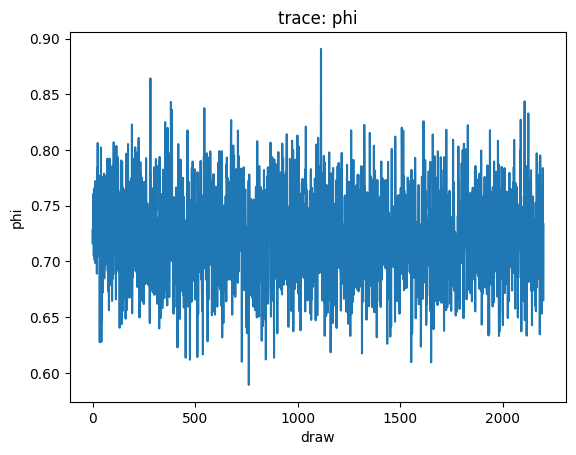

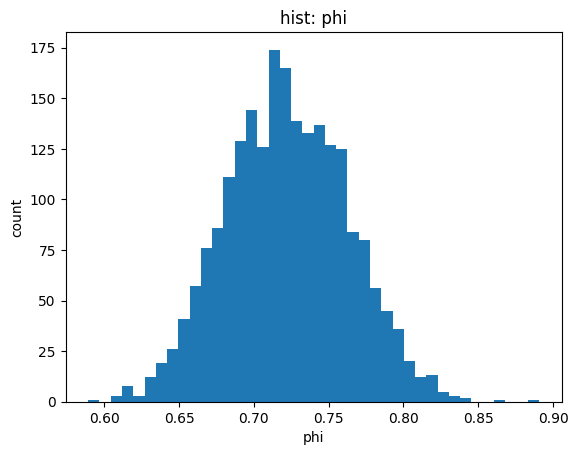

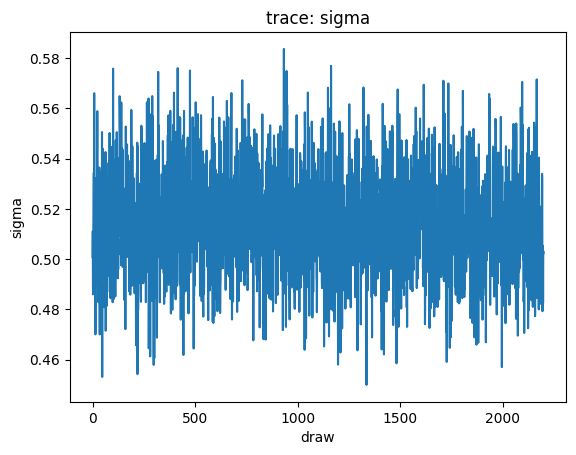

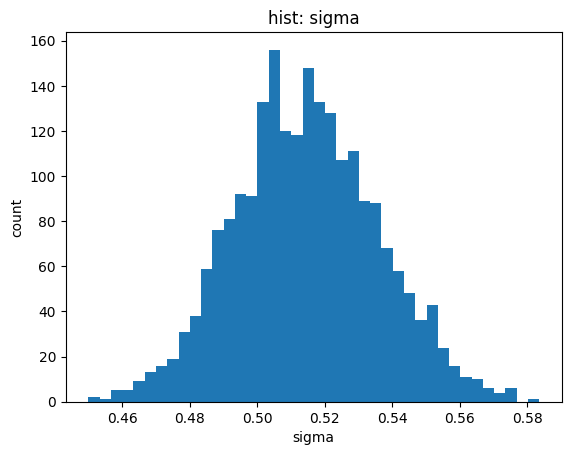

In [1]:
# ============================================================
# 完全版：AR(1) を MCMC（Gibbs）で推定（phi と sigma）
#  - NumPy + matplotlib だけ
#  - sigma^2 は Inverse-Gamma から「分布から直接」サンプル
#  - phi は 正規分布から「分布から直接」サンプル（条件付き）
# ============================================================

import numpy as np
import matplotlib.pyplot as plt


# -----------------------
# データ生成（AR(1)）
# y_t = phi*y_{t-1} + eps_t, eps_t ~ N(0, sigma^2)
# -----------------------
def simulate_ar1(T=300, phi=0.7, sigma=0.5, y0=0.0, seed=0):
    rng = np.random.default_rng(seed)
    y = np.empty(T, dtype=float)
    y[0] = y0
    eps = rng.normal(0.0, sigma, size=T - 1)
    for t in range(1, T):
        y[t] = phi * y[t - 1] + eps[t - 1]
    return y


# -----------------------
# 逆ガンマ(Inv-Gamma)サンプル
# もし X ~ Gamma(shape=a, scale=theta) なら 1/X ~ Inv-Gamma(a, b) に対応
# ここでは Inv-Gamma(a, b) の定義を
#   p(sigma2) ∝ (sigma2)^(-a-1) exp(-b/sigma2)
# とし、sigma2 = 1 / Gamma(a, scale=1/b) で生成する
# -----------------------
def inv_gamma_sample(rng, a, b):
    return 1.0 / rng.gamma(shape=a, scale=1.0 / b)


# -----------------------
# Gibbs サンプラー（phi, sigma^2）
# prior:
#   phi ~ Normal(mu_phi, s_phi^2) ただし定常性のため |phi|<1 を強制（切り捨て）
#   sigma^2 ~ Inv-Gamma(a0, b0)
# likelihood:
#   y_t | y_{t-1},phi,sigma^2 ~ Normal(phi*y_{t-1}, sigma^2), t=2..T
# -----------------------
def gibbs_ar1(
    y,
    n_iter=30000,
    burn=8000,
    thin=10,
    mu_phi=0.0,
    s_phi=1.0,
    a0=2.0,
    b0=1.0,
    init_phi=0.0,
    init_sigma2=1.0,
    seed=42,
    enforce_stationarity=True,
):
    rng = np.random.default_rng(seed)

    y1 = y[:-1]
    y2 = y[1:]
    n = len(y2)

    phi = float(init_phi)
    sigma2 = float(init_sigma2)

    keep_phi = []
    keep_sigma = []

    draws_target = max(0, (n_iter - burn + thin - 1) // thin)

    for i in range(n_iter):
        # 1) phi | sigma^2, y ~ Normal
        # posterior var/mean:
        #   V = 1 / (sum(y1^2)/sigma2 + 1/s_phi^2)
        #   M = V * (sum(y1*y2)/sigma2 + mu_phi/s_phi^2)
        Sxx = float(y1 @ y1)
        Sxy = float(y1 @ y2)

        V_phi = 1.0 / (Sxx / sigma2 + 1.0 / (s_phi * s_phi))
        M_phi = V_phi * (Sxy / sigma2 + mu_phi / (s_phi * s_phi))

        # 定常性 |phi|<1 を入れるなら、単純に「拒否再サンプル」で切り捨て正規にする
        if enforce_stationarity:
            while True:
                phi_prop = rng.normal(M_phi, np.sqrt(V_phi))
                if abs(phi_prop) < 1.0:
                    phi = phi_prop
                    break
        else:
            phi = rng.normal(M_phi, np.sqrt(V_phi))

        # 2) sigma^2 | phi, y ~ Inv-Gamma
        resid = y2 - phi * y1
        a_post = a0 + n / 2.0
        b_post = b0 + 0.5 * float(resid @ resid)
        sigma2 = inv_gamma_sample(rng, a_post, b_post)

        # keep
        if i >= burn and ((i - burn) % thin == 0):
            keep_phi.append(phi)
            keep_sigma.append(np.sqrt(sigma2))
            if len(keep_phi) >= draws_target:
                # 予定数に達したら抜けてもいい（無駄計算を減らす）
                pass

    return np.array(keep_phi), np.array(keep_sigma)


# -----------------------
# 要約（平均・中央値・信用区間）
# -----------------------
def summarize(name, x):
    q = np.quantile(x, [0.05, 0.5, 0.95])
    print(f"{name}")
    print(f"  mean   = {x.mean():.6f}")
    print(f"  median = {q[1]:.6f}")
    print(f"  5%     = {q[0]:.6f}")
    print(f"  95%    = {q[2]:.6f}")
    print("")


# -----------------------
# 実行例（そのまま動きます）
# -----------------------
if __name__ == "__main__":
    # 真値（例）
    phi_true = 0.7
    sigma_true = 0.5

    # データ
    y = simulate_ar1(T=300, phi=phi_true, sigma=sigma_true, seed=0)

    # MCMC
    phis, sigmas = gibbs_ar1(
        y,
        n_iter=30000,
        burn=8000,
        thin=10,
        mu_phi=0.0,
        s_phi=1.0,
        a0=2.0,
        b0=1.0,
        init_phi=0.0,
        init_sigma2=1.0,
        seed=42,
        enforce_stationarity=True,
    )

    # 要約
    print("true values")
    print(f"  phi   = {phi_true}")
    print(f"  sigma = {sigma_true}")
    print("")
    summarize("phi posterior", phis)
    summarize("sigma posterior", sigmas)

    # 簡単な可視化（トレース + ヒスト）
    fig = plt.figure()
    plt.plot(phis)
    plt.title("trace: phi")
    plt.xlabel("draw")
    plt.ylabel("phi")
    plt.show()

    fig = plt.figure()
    plt.hist(phis, bins=40)
    plt.title("hist: phi")
    plt.xlabel("phi")
    plt.ylabel("count")
    plt.show()

    fig = plt.figure()
    plt.plot(sigmas)
    plt.title("trace: sigma")
    plt.xlabel("draw")
    plt.ylabel("sigma")
    plt.show()

    fig = plt.figure()
    plt.hist(sigmas, bins=40)
    plt.title("hist: sigma")
    plt.xlabel("sigma")
    plt.ylabel("count")
    plt.show()
